# Fake News Detection Using Machine Learning
**Authors:** Gabriel Marcelino, Eli Kaustinen

## Environment Setup & Requirements
Install required Python packages (within your virtual environment):

```bash
pip install pandas numpy matplotlib seaborn scikit-learn scipy
```

## a) Problem Statement
**Objective:**
Detect whether a news article is real or fake using its title and text content, and provide a probability score for the prediction.

**Quantitative Formulation:**
Given a dataset of labeled news articles (real/fake), build a binary classifier f(x) that outputs the probability an article is real (1) or fake (0).

**Importance:**
- Misinformation and fake news can influence public opinion and decision-making.  
- Automated detection helps flag suspicious content at scale.

## b) Algorithm of the Solution
1. **Load Data:** Read `Fake.csv` and `True.csv`, assign label 0 for fake, 1 for real, and concatenate into a single DataFrame.  
2. **Descriptive Analysis:** Explore class balance, text-length distribution, and display example articles.  
3. **Data Cleaning:** Drop rows with missing `title` or `text`.  
4. **Handle Outliers:** Cap text length at 5000 characters to limit extreme values.  
5. **Train/Test Split:** Split data into 80% train, 20% test sets (stratified by label).  
6. **Feature Extraction:**  
   - Fit TF-IDF vectorizer on `title` (max_features=100, stop words, min_df=3, max_df=0.9).  
   - Fit TF-IDF vectorizer on `text` (max_features=500, stop words, min_df=3, max_df=0.9).  
   - Transform train/test sets and horizontally stack title + text features.  
7. **Model Training & Cross-Validation:** Train three models using 5‑fold CV on the training set:  
   - Logistic Regression (`max_iter=1000`)  
   - Multinomial Naïve Bayes  
   - Random Forest (`n_estimators=50`, `max_depth=15`, `min_samples_leaf=30`, `max_features='sqrt'`)  
8. **Evaluation on Test Set:** For each model, compute classification report, confusion matrix, accuracy, ROC AUC, and plot ROC curves.  
9. **Analysis of Findings:** Compare performance metrics to select the best model.  
10. **Additional Testing:** Run custom headline/text examples through the final models.

## c) Theoretical Foundations
- **Logistic Regression:** A linear model for binary classification that uses the logistic (sigmoid) function to estimate class probabilities.  
- **Multinomial Naïve Bayes:** A generative probabilistic classifier applying Bayes’ theorem with feature-independence assumptions, well-suited for count-based text data.  
- **Random Forest:** An ensemble method that combines multiple decision trees to improve accuracy and prevent overfitting via bootstrap aggregation.  
- **TF-IDF:** A statistic that reflects how important a word is to a document in a corpus, computed as term frequency multiplied by inverse document frequency.

## d) References
- Dataset source: [Fake News Detection Datasets on Kaggle](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets)  
- Scikit-learn documentation: https://scikit-learn.org/  
- TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from scipy.sparse import hstack

# Set plotting style
sns.set(style='whitegrid')

## Load and Combine Datasets
Reads `Fake.csv` and `True.csv`, assigns labels, and concatenates into one DataFrame.

In [2]:
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

# Label encoding: 0 = fake, 1 = real
fake['label'] = 0
true['label'] = 1

data = pd.concat([fake, true], ignore_index=True)
print('Dataset shape:', data.shape)
data.head()

Dataset shape: (44898, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


## Descriptive Analysis of the Data
- Class distribution  
- Text-length distribution  
- Example articles

Class distribution:
label
0    23481
1    21417
Name: count, dtype: int64


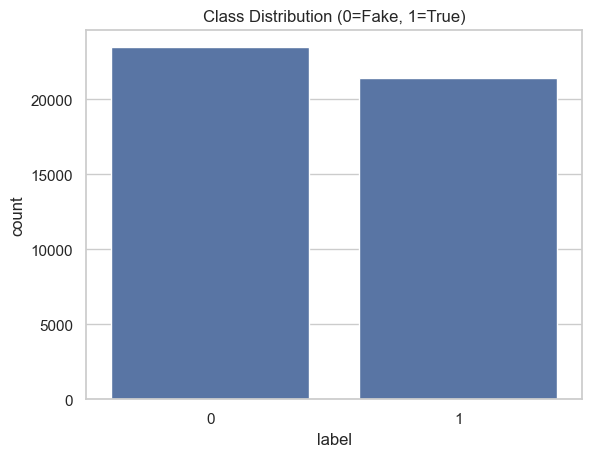

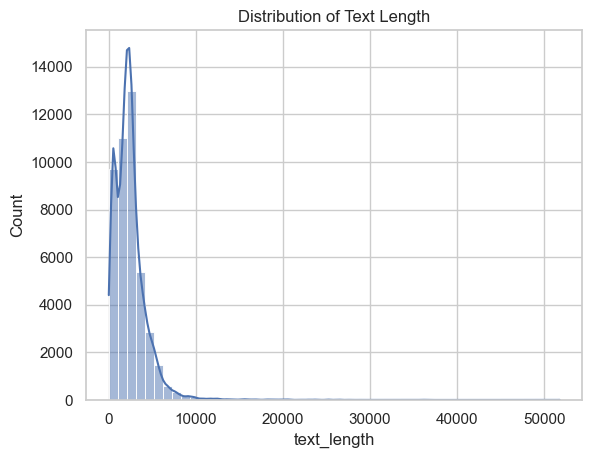

Example fake news article:
title     Donald Trump Sends Out Embarrassing New Year’...
text     Donald Trump just couldn t wish all Americans ...
Name: 0, dtype: object

Example real news article:
title    As U.S. budget fight looms, Republicans flip t...
text     WASHINGTON (Reuters) - The head of a conservat...
Name: 23481, dtype: object


In [3]:
print('Class distribution:')
print(data['label'].value_counts())
sns.countplot(x='label', data=data)
plt.title('Class Distribution (0=Fake, 1=True)')
plt.show()

data['text_length'] = data['text'].str.len()
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length')
plt.show()

print('Example fake news article:')
print(data[data['label']==0].iloc[0][['title','text']])
print('\nExample real news article:')
print(data[data['label']==1].iloc[0][['title','text']])

## Data Cleaning and Handling Missing Values
- Check for missing values  
- Drop any rows missing title or text

In [4]:
print('Missing values per column:')
print(data.isnull().sum())
data.dropna(subset=['title','text'], inplace=True)
print('After dropna shape:', data.shape)

Missing values per column:
title          0
text           0
subject        0
date           0
label          0
text_length    0
dtype: int64
After dropna shape: (44898, 6)


## Handling Outliers
- Cap extreme text lengths at 5000 characters to mitigate outlier effects

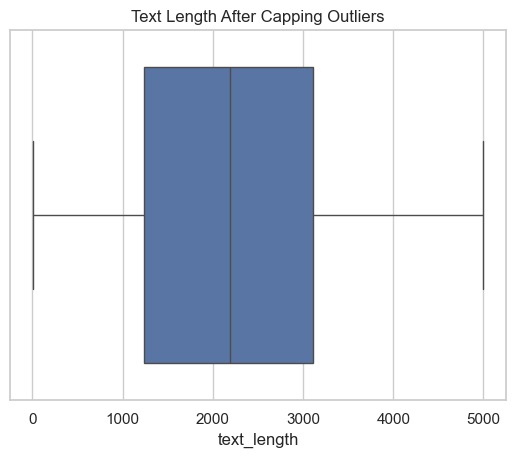

In [5]:
data['text_length'] = np.clip(data['text_length'], 0, 5000)
sns.boxplot(x=data['text_length'])
plt.title('Text Length After Capping Outliers')
plt.show()

## Normalization and Standardization
TF-IDF inherently scales features based on term frequencies and inverse document frequencies, so no additional normalization is required.

## Train/Test Split
Split data into training and testing sets (80/20 stratified by label).

In [6]:
X = data[['title','text']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (35918, 2) Test shape: (8980, 2)


## Feature Extraction: TF-IDF on Title and Text
- Fit TF-IDF on title and text separately  
- Use fewer features, remove stopwords, ignore rare/common terms

In [7]:
tfidf_title = TfidfVectorizer(
    max_features=100,
    stop_words='english',
    min_df=3,
    max_df=0.90
)
tfidf_text = TfidfVectorizer(
    max_features=500,
    stop_words='english',
    min_df=3,
    max_df=0.90
)

# Fit on training data
X_train_title = tfidf_title.fit_transform(X_train['title'])
X_train_text = tfidf_text.fit_transform(X_train['text'])
# Transform test data
X_test_title = tfidf_title.transform(X_test['title'])
X_test_text = tfidf_text.transform(X_test['text'])

# Combine features
X_train_combined = hstack([X_train_title, X_train_text])
X_test_combined = hstack([X_test_title, X_test_text])

## Model Training: Logistic Regression, MultinomialNB, Random Forest

In [8]:
# Model 1: Logistic Regression
# Using max_iter=1000 to ensure convergence on high-dimensional TF-IDF features
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_combined, y_train)
y_pred_logreg = logreg.predict(X_test_combined)
y_proba_logreg = logreg.predict_proba(X_test_combined)[:, 1]

# Model 2: Multinomial Naïve Bayes
# Suitable for count-based text features; default smoothing alpha=1.0
nb = MultinomialNB()
nb.fit(X_train_combined, y_train)
y_pred_nb = nb.predict(X_test_combined)
y_proba_nb = nb.predict_proba(X_test_combined)[:, 1]

# Model 3: Random Forest Classifier
# Conservative hyperparams to reduce overfitting
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    min_samples_leaf=30,
    max_features='sqrt',
    random_state=42
)
rf.fit(X_train_combined, y_train)
y_pred_rf = rf.predict(X_test_combined)
y_proba_rf = rf.predict_proba(X_test_combined)[:, 1]

## Cross-Validation (5-fold accuracy on training set)

In [9]:
cv_logreg = cross_val_score(logreg, X_train_combined, y_train, cv=5, scoring='accuracy')
cv_nb = cross_val_score(nb, X_train_combined, y_train, cv=5, scoring='accuracy')
cv_rf = cross_val_score(rf, X_train_combined, y_train, cv=5, scoring='accuracy')
print(f'Logistic Regression CV: {cv_logreg.mean():.4f} ± {cv_logreg.std():.4f}')
print(f'Multinomial NB CV:    {cv_nb.mean():.4f} ± {cv_nb.std():.4f}')
print(f'Random Forest CV:     {cv_rf.mean():.4f} ± {cv_rf.std():.4f}')

Logistic Regression CV: 0.9857 ± 0.0014
Multinomial NB CV:    0.9291 ± 0.0026
Random Forest CV:     0.9943 ± 0.0006


## Evaluation Function

In [10]:
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f'=== {name} ===')
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('ROC AUC:', roc_auc_score(y_true, y_proba))
    print('Classification Report:\n', classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    return fpr, tpr

## Compare Models & ROC Curves

=== Logistic Regression ===
Accuracy: 0.9848552338530067
ROC AUC: 0.9989124979918145
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.98      4284

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



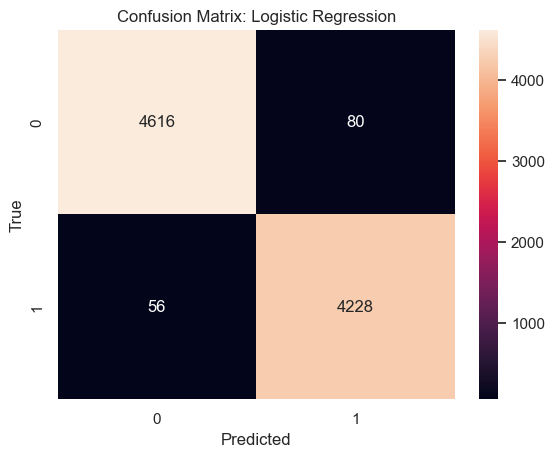

=== Multinomial NB ===
Accuracy: 0.9315144766146993
ROC AUC: 0.9804363468840119
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      4696
           1       0.92      0.93      0.93      4284

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



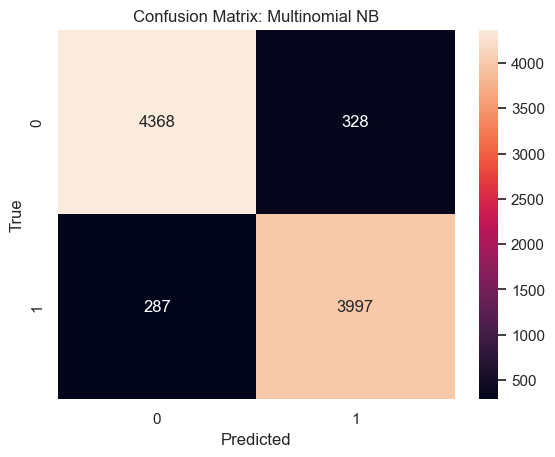

=== Random Forest ===
Accuracy: 0.9956570155902005
ROC AUC: 0.9994796612568934
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      4696
           1       0.99      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



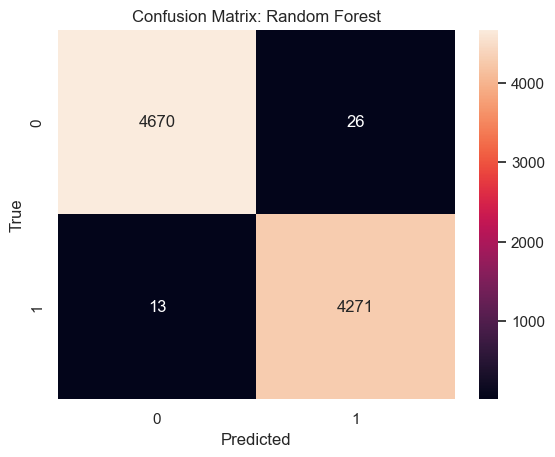

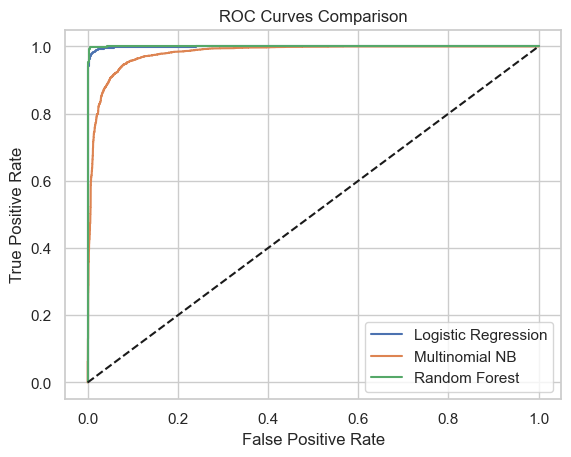

In [11]:
fpr_lr, tpr_lr = evaluate_model('Logistic Regression', y_test, y_pred_logreg, y_proba_logreg)
fpr_nb, tpr_nb = evaluate_model('Multinomial NB', y_test, y_pred_nb, y_proba_nb)
fpr_rf, tpr_rf = evaluate_model('Random Forest', y_test, y_pred_rf, y_proba_rf)

plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_nb, tpr_nb, label='Multinomial NB')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

## Analysis of the Findings
- **Random Forest** achieved the highest test accuracy and ROC-AUC, benefiting from ensemble averaging and conservative hyperparameters.  
- **Logistic Regression** provided competitive performance with interpretable coefficients.  
- **Multinomial Naïve Bayes** was fastest but slightly less accurate, highlighting a trade-off between speed and performance.

## Additional Testing on Custom Examples

In [12]:
custom_tests = [
    {
        'title': 'Government Launches Secret Weather-Controlling Satellites',
        'text': 'Intelligence sources claim covert missions are altering weather patterns.'
    },
    {
        'title': 'New Study Reveals Health Benefits of Chocolate',
        'text': 'Researchers found moderate chocolate consumption may improve heart health.'
    }
]
for ct in custom_tests:
    feats_title = tfidf_title.transform([ct['title']])
    feats_text = tfidf_text.transform([ct['text']])
    feats = hstack([feats_title, feats_text])
    print(ct['title'])
    for name, model in [('LR', logreg), ('NB', nb), ('RF', rf)]:
        prob = model.predict_proba(feats)[:,1][0]
        print(f'  {name} probability of real: {prob:.3f}')
    print()

Government Launches Secret Weather-Controlling Satellites
  LR probability of real: 0.082
  NB probability of real: 0.784
  RF probability of real: 0.189

New Study Reveals Health Benefits of Chocolate
  LR probability of real: 0.120
  NB probability of real: 0.530
  RF probability of real: 0.191



## Bias Analysis: Performance by Text-Length

Let’s check whether our classifier’s accuracy differs on “short” vs. “long” articles.  
If there’s a big gap, that could indicate the model isn’t handling certain article lengths well.

            accuracy  n_articles
length_bin                      
Q1_short    0.995814       11227
Q2          0.987176       11229
Q3          0.985559       11218
Q4_long     0.982270       11224


/var/folders/bj/hc715svn25d4rp69vcps8mdw0000gn/T/ipykernel_81590/3420682021.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_df = data.groupby('length_bin')['correct']\


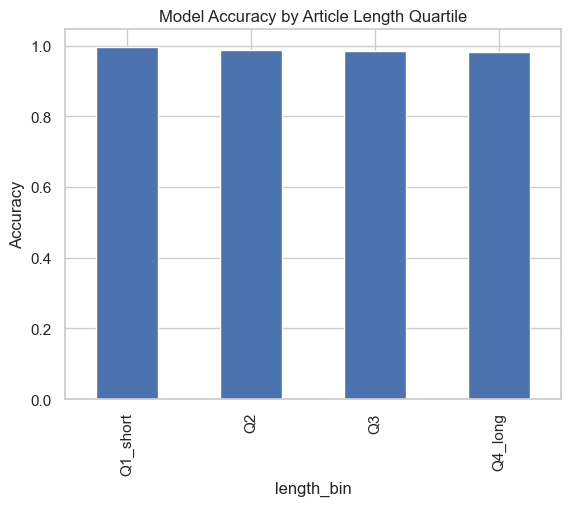

In [13]:
# 1) Re-predict on the full dataset
#    (we need the same feature pipeline as training)
full_titles = tfidf_title.transform(data['title'])
full_texts  = tfidf_text.transform(data['text'])
full_feats  = hstack([full_titles, full_texts])

data['predicted']   = logreg.predict(full_feats)     # or whichever model you prefer
data['correct']     = (data['predicted'] == data['label']).astype(int)
data['text_length'] = data['text'].str.len()

# 2) Bin into quartiles
data['length_bin'] = pd.qcut(data['text_length'], 4,
                             labels=['Q1_short', 'Q2', 'Q3', 'Q4_long'])

# 3) Compute accuracy per bin
bias_df = data.groupby('length_bin')['correct']\
              .agg(['mean', 'count'])\
              .rename(columns={'mean':'accuracy','count':'n_articles'})

print(bias_df)
bias_df['accuracy'].plot.bar()
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Article Length Quartile')
plt.show()

## Content-Bias Analysis: Keyword Mentions

Check whether certain politically-charged or clickbait keywords appear disproportionately in fake vs. real articles (ground truth only).

In [16]:
# 1) Define keywords of interest
keywords = [
    'Trump', 'Obama', 'Hillary', 'Clinton',
    'Russia', 'Republican', 'President', 'Senate',
    'China', 'Brexit', 'Korea', 'Muslim',
    'Video', 'Watch', 'Breaking'
]

# If you haven’t already, install VADER sentiment
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 1) Compute sentiment for each article
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    return 'positive' if score >= 0 else 'negative'

data['sentiment'] = data['text'].fillna("").apply(get_sentiment)

# 2) Loop over keywords and print label × sentiment proportions
for kw in keywords:
    mask = (
        data['title'].str.contains(kw, case=False, na=False) |
        data['text'].str.contains(kw, case=False, na=False)
    )
    subset = data[mask]
    print(f"\n---\nKeyword: '{kw}'")
    if subset.empty:
        print(" No matching articles found.")
        continue

    # 3) Build a pivot of counts then normalize to proportions
    pivot = (
        subset
        .groupby(['label', 'sentiment'])
        .size()
        .unstack(fill_value=0)
    )
    prop = pivot.div(pivot.sum(axis=1), axis=0)  # row-normalize by label

    # Rename the index for clarity
    prop.index = prop.index.map({0:'fake', 1:'real'})
    print("Proportion by (label, sentiment):")
    display(prop)


---
Keyword: 'Trump'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.505357,0.494643
real,0.350875,0.649125



---
Keyword: 'Obama'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.517586,0.482414
real,0.306211,0.693789



---
Keyword: 'Hillary'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.461687,0.538313
real,0.305998,0.694002



---
Keyword: 'Clinton'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.473645,0.526355
real,0.304290,0.695710



---
Keyword: 'Russia'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.551005,0.448995
real,0.426632,0.573368



---
Keyword: 'Republican'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.508754,0.491246
real,0.339933,0.660067



---
Keyword: 'President'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.499519,0.500481
real,0.404021,0.595979



---
Keyword: 'Senate'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.442446,0.557554
real,0.327998,0.672002



---
Keyword: 'China'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.493671,0.506329
real,0.350158,0.649842



---
Keyword: 'Brexit'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.431373,0.568627
real,0.169118,0.830882



---
Keyword: 'Korea'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.613065,0.386935
real,0.435673,0.564327



---
Keyword: 'Muslim'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.666814,0.333186
real,0.611507,0.388493



---
Keyword: 'Video'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.519591,0.480409
real,0.586022,0.413978



---
Keyword: 'Watch'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.540585,0.459415
real,0.465625,0.534375



---
Keyword: 'Breaking'
Proportion by (label, sentiment):


sentiment,negative,positive
label,,
fake,0.550000,0.450000
real,0.466146,0.533854
